In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import stuff relevant to HTML scraping
import requests
import re

In [2]:
# Option to save plots
SavePlots = True

# Extract the Data from the website
First accessed: 22.11, 15/02/2022

In [3]:
# Define path to the saved webarchive files
path_09 = '2009_Pomeroy_College_Basketball_Ratings.html'
path_14 = '2014_Pomeroy_College_Basketball_Ratings.html'

# Read the files (We observe that the header contain 17 rows that are unnamed, we remove those)
# The read_html function returns a list of dataframes, since there is only one we unpack this by using [0]

# We also need to skip certain row because the header repeats itself, index found by inspection
row_id_to_skip = np.array([40, 41, 82, 83, 124, 125, 166, 167, 208, 209, 250, 251, 292, 293, 334, 335])
n_header = 17

# The counter sort of stars at the header, the rows with number after therefor we plus with n_header +1??
df_09_raw = pd.read_html(path_09, skiprows = row_id_to_skip+n_header+1, header = n_header)[0]
df_14_raw = pd.read_html(path_14, skiprows = row_id_to_skip+n_header+1, header = n_header)[0]

# Test we have the right number of teams
N_teams_09 = len(df_09_raw)
N_teams_14 = len(df_14_raw)
print(f'Pandas found {N_teams_09} teams in 2009 and {N_teams_14} in 2014')

Pandas found 344 teams in 2009 and 351 in 2014


In [4]:
# Lets extract the columns we are actually interested in

# Define those column-names
Used_cols = ['Team','Conf','AdjD','AdjO']

# Extract them from the dataframe
df_09 = df_09_raw[Used_cols]
df_14 = df_14_raw[Used_cols]

# Remove anything not in the English Alphabet with regex and pandas replace and return new cleaned dataframe
df_09_clean = df_09.copy()
df_14_clean = df_14.copy()
df_09_clean['Team'] = df_09['Team'].replace(to_replace='[^A-Za-z]', value='', regex=True) #I ALSO REMOVE DIGITS FROM CONF
df_14_clean['Team'] = df_14['Team'].replace(to_replace='[^A-Za-z]', value='', regex=True)

Now that we have what we need, lets begin solving the questions.

# Adjusted Defense Histogram

In [5]:
def Adjusted_defense(conf_name, year):
    """
    Function that takes the conference we are interested in and returns a list of the adjusted 
    defense scores for the teams included in the conference.
    
    conf_name = a string, fx. 'ACC' or 'SEC' (should be included in the conf column)
    year = a string, either '2009' or '2014'
    """
    
    # Select the right year
    if year == '2009': dataframe = df_09_clean
    if year == '2014': dataframe = df_14_clean
    else: print('Select 2009 or 2014 as the year. Remember it should be in a string.')
    
    # Create a mask that tells us which indices correspond to the given conference
    conf_mask = (dataframe['Conf'] == conf_name)
    
    # Return the adjusted defense scores for the conference teams
    return dataframe['AdjD'][conf_mask].to_numpy()

In [6]:
# Define the conferences wanted in exercise 1
wanted_conf = ['ACC','SEC','B10','BSky','A10']

# Extract the data
AdjD_ex1 = []
for i in range(len(wanted_conf)):
    AdjD_ex1.append( Adjusted_defense(conf_name=wanted_conf[i], year='2014') )

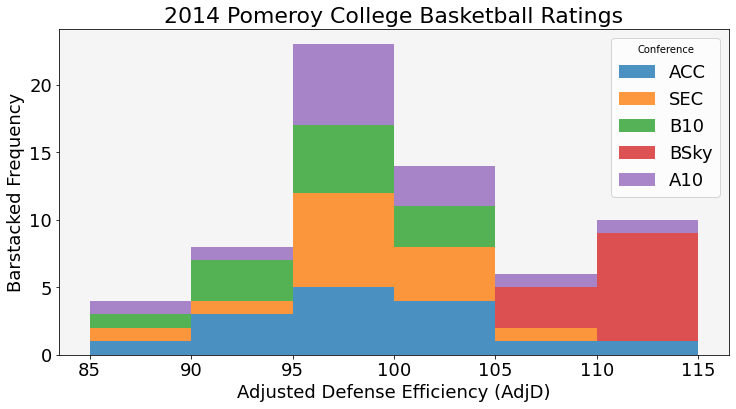

In [7]:
#### Plotting ####

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(AdjD_ex1, bins=np.arange(85,116,5), histtype='barstacked', linewidth=2, alpha=0.8, label=wanted_conf)

# aesthetics
ax.legend(prop={'size':18}, title='Conference')
ax.set_xlabel('Adjusted Defense Efficiency (AdjD)', fontsize=18)
ax.set_ylabel('Barstacked Frequency', fontsize=18)
ax.set_title('2014 Pomeroy College Basketball Ratings', fontsize=22)
ax.set_facecolor('whitesmoke')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Option to save plots
if SavePlots:
    plt.savefig('exercise1.pdf')
plt.show()

# Difference in AdjO between 09' and 14' for All Teams

We need to check two things first:
- (1) That if a team appears both in 2009 and 2014 it should be in the same conference for us to be able to calculate the mean and median of the difference for one conference.
- (2) That the team names are EXACTLY the same for the two conferences, i.e. that the scraping did not add additional spaces or something like that.

In [8]:
### Test uniqueness of team names ###
test = np.concatenate( [ df_09_clean['Team'].to_numpy(), df_14_clean['Team'].to_numpy() ])
test_uniq = np.unique(test)
print(f'There are {len(test_uniq)} unique teams, which is more than the {N_teams_14} teams in 2014')
print('Some names must therefor have been altered unless some just dissapeared and new ones came in')

There are 353 unique teams, which is more than the 351 teams in 2014
Some names must therefor have been altered unless some just dissapeared and new ones came in


Since we have already removed anything not in the english alphabet, i.e. spaces, digits, special characters etc. and we can confirm this by printing the variable test, we know that there must in fact be 353 unique teams. This mean some teams must have only participated in one year. <br>

We will test whether teams always compete in the same conference if they appear both years later, when we have constructed functions for extracting and matching team names.

In [9]:
def extract_team_names(conf_name, year):
    """
    Function that takes the conference and year we are interested in, and returns a list of the 
    teams that are in that conference for that given year.
    
    conf_name = a string, fx. 'ACC' or 'SEC' (should be included in the conf column)
    year = a string, either '2009' or '2014'
    """
    
    # Select the right year
    if year == '2009': dataframe = df_09_clean
    elif year == '2014': dataframe = df_14_clean
    else: print('Select 2009 or 2014 as the year. Remember it should be in a string.')
    
    # Create a mask that tells us which indices correspond to the given conference
    conf_mask = (dataframe['Conf'] == conf_name)
    
    # Return the team names for those in the right conference
    return dataframe['Team'][conf_mask].to_numpy()


def match_team_names(team_names_A, team_names_B):
    """
    Function that takes two list of team names and returns a list of the teams that occur both places.
    
    team_names_A: the first list of team names to be matched with..
    team_names_B: the next list of team names (both are list of strings)
    """
    
    # First we need to concatenate the two lists
    AB_concat = np.concatenate([team_names_A, team_names_B])
    
    # Use np.unique to get all unique teams and their counts
    uniq_list, uniq_count = np.unique(AB_concat, return_counts=True)
    
    # The teams with a count of 2 are the teams that are in both lists
    return uniq_list[uniq_count==2]

In [10]:
### Test for whether a team is always in the same conf ###

# Match all teams from 09' and 14'
matched_teams = match_team_names(df_09_clean['Team'], df_14_clean['Team'])

# Check if the conferences are the same

# Set up a counter for counting the number of teams with difference conf for each year
diff_conf_cntr = 0

for i in range(len(matched_teams)):
    
    # Get team name of that iteration
    team_ = matched_teams[i]
    
    # Get 09 conference of that team name
    conf_name_09_ = df_09_clean['Conf'].to_numpy()[df_09_clean['Team'] == team_]
    
    # Get 14 conference of that team name
    conf_name_14_ = df_14_clean['Conf'].to_numpy()[df_14_clean['Team'] == team_]
    
    # If the conferences are not the same, count it as an error
    if conf_name_09_ != conf_name_14_:
        diff_conf_cntr += 1
        #print(i,conf_name_09_,conf_name_14_) #uncomment for more verbose
    
print(diff_conf_cntr)

78


So 78 teams move from one conference to another between the years 2009 and 2014. Now lets move on and make the function that actually calculates the adjusted defence efficiency difference.

In [11]:
def Adjusted_offense_diff(team_names):
    """
    Calculates the difference in adjusted offense (2014-2009) for the given teams.
    Returns both the difference and the value in 2009, along with the conference they belong to
    or the string 'Moved Conf' if they moved to another conference from 2009 to 2014.
    
    team_names = list of strings giving the team names (this assume the team is in both years)
    
    This could be done better with array programming rather than a for loop, 
    but i am not yet to familiar with pandas
    """
    
    # Make array for what we want to save
    adj_off_diff_arr = []
    adj_off_09_arr = []
    conf_names = []
    
    # Loop over the given team names
    for i in range(len(team_names)):
        
        # Create a mask selecting the right team for each year
        team_=team_names[i]
        mask_09 = (df_09_clean['Team'] == team_)
        mask_14 = (df_14_clean['Team'] == team_)
        
        # Get the adjusted defense for 09 and 14
        adj_off_09_val = df_09_clean['AdjO'].to_numpy()[mask_09][0]
        adj_off_14_val = df_14_clean['AdjO'].to_numpy()[mask_14][0]

        # Get the adjusted defense 
        adj_off_diff_val = adj_off_14_val - adj_off_09_val

        # Get the conference for each of the teams
        conf_09_val = df_09_clean['Conf'].to_numpy()[mask_09]
        conf_14_val = df_14_clean['Conf'].to_numpy()[mask_14]
        
        # Now we append all values we want to return
        adj_off_diff_arr.append(adj_off_diff_val)
        adj_off_09_arr.append(adj_off_09_val)
        
        # Chech whether they moved conferences (0 if they didnt, 1 if they did)
        if conf_09_val == conf_14_val: 
            conf_names.append(conf_09_val[0])
        else:
            conf_names.append('Moved Conf')
            
    return np.array([adj_off_diff_arr]), np.array([adj_off_09_arr]), np.array([conf_names])

## For the 5 conferences of exercise 1

In [12]:
# Get the team names of the conference for each year
teams_ex2 = []

for i in range(len(wanted_conf)):
    
    teams_09 = extract_team_names(conf_name=wanted_conf[i], year='2009') 
    teams_14 = extract_team_names(conf_name=wanted_conf[i], year='2014')
    
    # Match the teams from each year
    teams_ex2.append( match_team_names(teams_09, teams_14) )

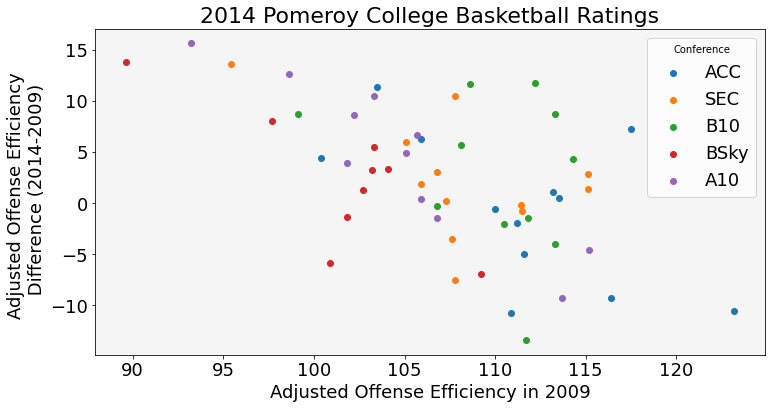

In [13]:
### Plotting ###
fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(wanted_conf)):
    
    diff, val_09, _ = Adjusted_offense_diff(teams_ex2[i])
    ax.scatter(val_09, diff, label=wanted_conf[i])
    ax.legend()

# aesthetics
ax.legend(prop={'size':18}, title='Conference')
ax.set_xlabel('Adjusted Offense Efficiency in 2009', fontsize=18)
ax.set_ylabel(f'Adjusted Offense Efficiency \n Difference (2014-2009)', fontsize=18)
ax.set_title('2014 Pomeroy College Basketball Ratings', fontsize=22)
ax.set_facecolor('whitesmoke')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Option to save plots
if SavePlots:
    plt.savefig('exercise21.pdf')
plt.show()

## Calculate the difference in “AdjO” for all the teams with data in both 2009 and 2014

In [14]:
# First we match all team from each year (we did this before also)
matched_teams = match_team_names(df_09_clean['Team'], df_14_clean['Team'])

# Get adjusted defense values and conf
diff, off_09_val, conferences = Adjusted_offense_diff(matched_teams)

# Sort by conference to get new lists
uniq_conf = np.unique(conferences)
conf_diff = []
conf_off_09_val = []

# Loop over unique conferences
for conf_ in uniq_conf:
    
    # Create mask that select all in that conf
    mask = np.array( [i == conf_ for i in conferences], dtype=bool)
    
    # Append right values
    conf_diff.append( diff[mask] )
    conf_off_09_val.append( off_09_val[mask] )

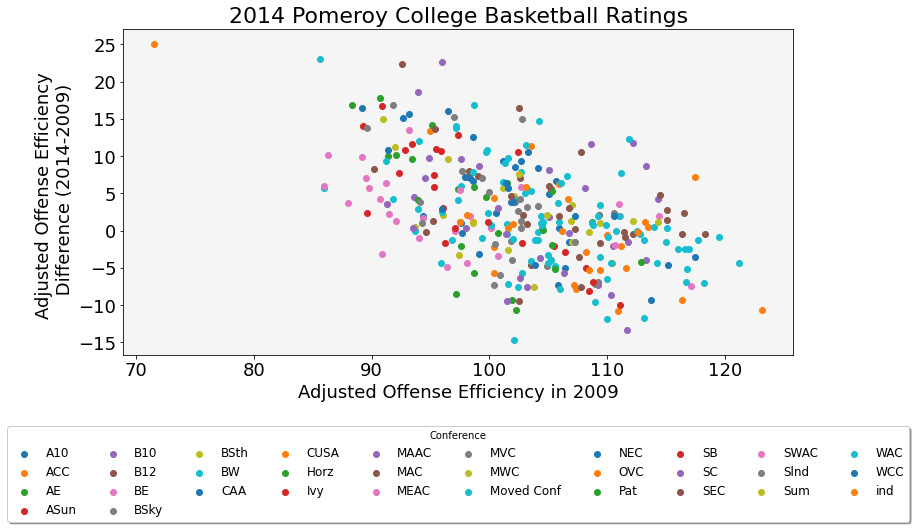

In [15]:
### Plotting ###

fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(uniq_conf)):
    
    ax.scatter(conf_off_09_val[i], conf_diff[i], label=uniq_conf[i])
    
# aesthetics
ax.legend(prop={'size':12}, title='Conference',loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=10, fancybox=True, shadow=True)
ax.set_xlabel('Adjusted Offense Efficiency in 2009', fontsize=18)
ax.set_ylabel(f'Adjusted Offense Efficiency \n Difference (2014-2009)', fontsize=18)
ax.set_title('2014 Pomeroy College Basketball Ratings', fontsize=22)
ax.set_facecolor('whitesmoke')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Option to save plots
if SavePlots:
    plt.savefig('exercise22.pdf')
plt.show()

plt.show()

In [16]:
# Calculate median and mean for each of the 5 conferences
wanted_conf_diff = []
wanted_conf_off_09_val = []

# Loop over wanted conferences
for conf_ in wanted_conf:
    
    # Create mask that select all in that conf
    mask = np.array( [i == conf_ for i in conferences], dtype=bool)
    
    # Append right values
    wanted_conf_diff.append( diff[mask] )
    wanted_conf_off_09_val.append( off_09_val[mask] )
    
# Calculate the means and median
wanted_means = []
wanted_medians = []
for i in range(len(wanted_conf)):
    
    wanted_means.append( np.mean(wanted_conf_diff[i]) )
    wanted_medians.append( np.median(wanted_conf_diff[i]) )
    
for i in range(len(wanted_conf)):    
    print(f'Conf: {wanted_conf[i]} \t mean = {wanted_means[i]:.3f} \t median = {wanted_medians[i]:.3f}')

Conf: ACC 	 mean = -0.625 	 median = -0.050
Conf: SEC 	 mean = 2.283 	 median = 1.650
Conf: B10 	 mean = 2.673 	 median = 4.300
Conf: BSky 	 mean = 2.322 	 median = 3.200
Conf: A10 	 mean = 4.336 	 median = 4.900


In [17]:
# Now we do the same for the teams not in the conferences

# Get non wanted conf
non_wanted_conf = []
for i in uniq_conf:
    if i not in wanted_conf:
        non_wanted_conf.append(i)
    
# EMpty lists to store
non_wanted_conf_diff = []
non_wanted_conf_off_09_val = []

# Loop over wanted conferences
for conf_ in non_wanted_conf:
    
    # Create mask that select all in that conf
    mask = np.array( [i == conf_ for i in conferences], dtype=bool)
    
    # Append right values
    non_wanted_conf_diff.append( diff[mask] )
    non_wanted_conf_off_09_val.append( off_09_val[mask] )
    
# Calculate the means and median
non_wanted_means = []
non_wanted_medians = []
for i in range(len(non_wanted_conf)):
    
    non_wanted_means.append( np.mean(non_wanted_conf_diff[i]) )
    non_wanted_medians.append( np.median(non_wanted_conf_diff[i]) )
    
for i in range(len(non_wanted_conf)):  
    if len(non_wanted_conf[i]) > 9:
        print(f'Conf: {non_wanted_conf[i]} \t mean = {non_wanted_means[i]:.3f} \t median = {non_wanted_medians[i]:.3f}')
    else:
        print(f'Conf: {non_wanted_conf[i]} \t \t mean = {non_wanted_means[i]:.3f} \t median = {non_wanted_medians[i]:.3f}')

Conf: AE 	 	 mean = -0.800 	 median = -0.450
Conf: ASun 	 	 mean = 3.289 	 median = 2.400
Conf: B12 	 	 mean = 2.850 	 median = 0.850
Conf: BE 	 	 mean = 1.143 	 median = 1.900
Conf: BSth 	 	 mean = 4.200 	 median = 3.350
Conf: BW 	 	 mean = 1.713 	 median = 0.800
Conf: CAA 	 	 mean = 4.150 	 median = 6.900
Conf: CUSA 	 	 mean = -2.550 	 median = -3.650
Conf: Horz 	 	 mean = 2.075 	 median = 2.300
Conf: Ivy 	 	 mean = 7.137 	 median = 9.000
Conf: MAAC 	 	 mean = 4.511 	 median = 4.500
Conf: MAC 	 	 mean = 3.983 	 median = 3.400
Conf: MEAC 	 	 mean = 2.991 	 median = 2.200
Conf: MVC 	 	 mean = 2.644 	 median = 2.600
Conf: MWC 	 	 mean = 1.100 	 median = 1.150
Conf: Moved Conf 	 mean = 1.237 	 median = 0.450
Conf: NEC 	 	 mean = 2.711 	 median = 2.400
Conf: OVC 	 	 mean = 0.830 	 median = 0.600
Conf: Pat 	 	 mean = 7.587 	 median = 7.700
Conf: SB 	 	 mean = 0.943 	 median = 0.400
Conf: SC 	 	 mean = -0.045 	 median = 0.300
Conf: SWAC 	 	 mean = 2.950 	 median = 2.700
Conf: Slnd 	 	 mean 

# Exercise 3: repeat with one more conference

## Exercise 1: histogram

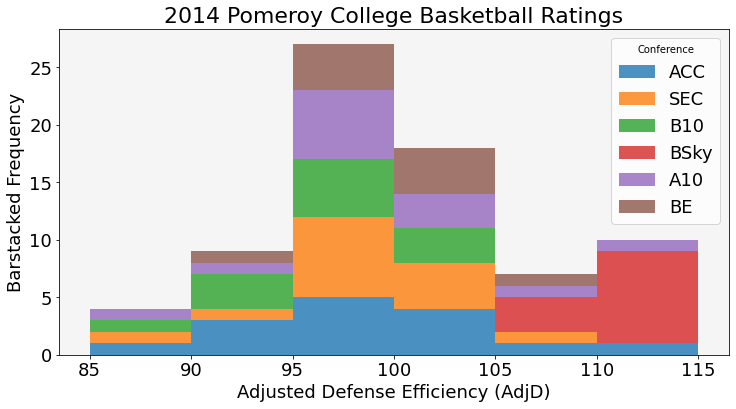

In [18]:
# Redefine new wanted conferences
wanted_conf = ['ACC','SEC','B10','BSky','A10','BE']

# Extract the data
AdjD_ex1 = []
for i in range(len(wanted_conf)):
    AdjD_ex1.append( Adjusted_defense(conf_name=wanted_conf[i], year='2014') )
    
#### Plotting ####

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(AdjD_ex1, bins=np.arange(85,116,5), histtype='barstacked', linewidth=2, alpha=0.8, label=wanted_conf)

# aesthetics
ax.legend(prop={'size':18}, title='Conference')
ax.set_xlabel('Adjusted Defense Efficiency (AdjD)', fontsize=18)
ax.set_ylabel('Barstacked Frequency', fontsize=18)
ax.set_title('2014 Pomeroy College Basketball Ratings', fontsize=22)
ax.set_facecolor('whitesmoke')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Option to save plots
if SavePlots:
    plt.savefig('exercise31.pdf')
plt.show()

## Exercise 2

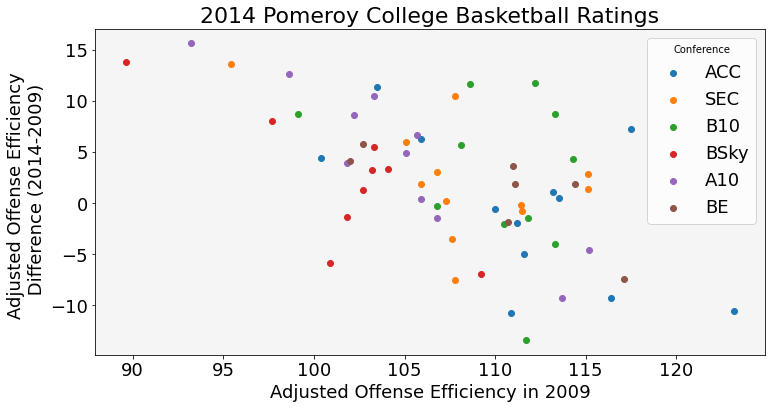

In [19]:
# Get the team names of the conference for each year
teams_ex2 = []

for i in range(len(wanted_conf)):
    
    teams_09 = extract_team_names(conf_name=wanted_conf[i], year='2009') 
    teams_14 = extract_team_names(conf_name=wanted_conf[i], year='2014')
    
    # Match the teams from each year
    teams_ex2.append( match_team_names(teams_09, teams_14) )
    
### Plotting ###
fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(wanted_conf)):
    
    diff, val_09, _ = Adjusted_offense_diff(teams_ex2[i])
    ax.scatter(val_09, diff, label=wanted_conf[i])
    ax.legend()

# aesthetics
ax.legend(prop={'size':18}, title='Conference')
ax.set_xlabel('Adjusted Offense Efficiency in 2009', fontsize=18)
ax.set_ylabel(f'Adjusted Offense Efficiency \n Difference (2014-2009)', fontsize=18)
ax.set_title('2014 Pomeroy College Basketball Ratings', fontsize=22)
ax.set_facecolor('whitesmoke')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Option to save plots
if SavePlots:
    plt.savefig('exercise32.pdf')
plt.show()

## Mean and meadians

In [20]:
# First we match all team from each year (we did this before also)
matched_teams = match_team_names(df_09_clean['Team'], df_14_clean['Team'])

# Get adjusted defense values and conf
diff, off_09_val, conferences = Adjusted_offense_diff(matched_teams)

# Sort by conference to get new lists
uniq_conf = np.unique(conferences)
conf_diff = []
conf_off_09_val = []

# Loop over unique conferences
for conf_ in uniq_conf:
    
    # Create mask that select all in that conf
    mask = np.array( [i == conf_ for i in conferences], dtype=bool)
    
    # Append right values
    conf_diff.append( diff[mask] )
    conf_off_09_val.append( off_09_val[mask] )

In [21]:
# Calculate median and mean for each of the 5 conferences
wanted_conf_diff = []
wanted_conf_off_09_val = []

# Loop over wanted conferences
for conf_ in wanted_conf:
    
    # Create mask that select all in that conf
    mask = np.array( [i == conf_ for i in conferences], dtype=bool)
    
    # Append right values
    wanted_conf_diff.append( diff[mask] )
    wanted_conf_off_09_val.append( off_09_val[mask] )
    
# Calculate the means and median
wanted_means = []
wanted_medians = []
for i in range(len(wanted_conf)):
    
    wanted_means.append( np.mean(wanted_conf_diff[i]) )
    wanted_medians.append( np.median(wanted_conf_diff[i]) )
    
for i in range(len(wanted_conf)):    
    print(f'Conf: {wanted_conf[i]} \t mean = {wanted_means[i]:.3f} \t median = {wanted_medians[i]:.3f}')

Conf: ACC 	 mean = -0.625 	 median = -0.050
Conf: SEC 	 mean = 2.283 	 median = 1.650
Conf: B10 	 mean = 2.673 	 median = 4.300
Conf: BSky 	 mean = 2.322 	 median = 3.200
Conf: A10 	 mean = 4.336 	 median = 4.900
Conf: BE 	 mean = 1.143 	 median = 1.900


In [22]:
# Now we do the same for the teams not in the conferences

# Get non wanted conf
non_wanted_conf = []
for i in uniq_conf:
    if i not in wanted_conf:
        non_wanted_conf.append(i)
    
# EMpty lists to store
non_wanted_conf_diff = []
non_wanted_conf_off_09_val = []

# Loop over wanted conferences
for conf_ in non_wanted_conf:
    
    # Create mask that select all in that conf
    mask = np.array( [i == conf_ for i in conferences], dtype=bool)
    
    # Append right values
    non_wanted_conf_diff.append( diff[mask] )
    non_wanted_conf_off_09_val.append( off_09_val[mask] )
    
# Calculate the means and median
non_wanted_means = []
non_wanted_medians = []
for i in range(len(non_wanted_conf)):
    
    non_wanted_means.append( np.mean(non_wanted_conf_diff[i]) )
    non_wanted_medians.append( np.median(non_wanted_conf_diff[i]) )
    
for i in range(len(non_wanted_conf)):  
    if len(non_wanted_conf[i]) > 9:
        print(f'Conf: {non_wanted_conf[i]} \t mean = {non_wanted_means[i]:.3f} \t median = {non_wanted_medians[i]:.3f}')
    else:
        print(f'Conf: {non_wanted_conf[i]} \t \t mean = {non_wanted_means[i]:.3f} \t median = {non_wanted_medians[i]:.3f}')

Conf: AE 	 	 mean = -0.800 	 median = -0.450
Conf: ASun 	 	 mean = 3.289 	 median = 2.400
Conf: B12 	 	 mean = 2.850 	 median = 0.850
Conf: BSth 	 	 mean = 4.200 	 median = 3.350
Conf: BW 	 	 mean = 1.713 	 median = 0.800
Conf: CAA 	 	 mean = 4.150 	 median = 6.900
Conf: CUSA 	 	 mean = -2.550 	 median = -3.650
Conf: Horz 	 	 mean = 2.075 	 median = 2.300
Conf: Ivy 	 	 mean = 7.137 	 median = 9.000
Conf: MAAC 	 	 mean = 4.511 	 median = 4.500
Conf: MAC 	 	 mean = 3.983 	 median = 3.400
Conf: MEAC 	 	 mean = 2.991 	 median = 2.200
Conf: MVC 	 	 mean = 2.644 	 median = 2.600
Conf: MWC 	 	 mean = 1.100 	 median = 1.150
Conf: Moved Conf 	 mean = 1.237 	 median = 0.450
Conf: NEC 	 	 mean = 2.711 	 median = 2.400
Conf: OVC 	 	 mean = 0.830 	 median = 0.600
Conf: Pat 	 	 mean = 7.587 	 median = 7.700
Conf: SB 	 	 mean = 0.943 	 median = 0.400
Conf: SC 	 	 mean = -0.045 	 median = 0.300
Conf: SWAC 	 	 mean = 2.950 	 median = 2.700
Conf: Slnd 	 	 mean = 3.067 	 median = 1.000
Conf: Sum 	 	 mean